In [166]:
import cv2
import numpy as np
import pandas as pd
import PIL.Image
from matplotlib import pyplot as plt
from glob import glob
from pathlib import Path
from scipy.spatial.transform import Rotation as R

SEED = 42
HOME = Path.cwd().parent
RAW_PATH = HOME / 'data/raw'

In [139]:
# !pip install opencv-python

In [140]:
def show_raw(image):
    image_show = np.copy(image)
    image_show = cv2.cvtColor(image_show,cv2.COLOR_BGR2RGB)
    plt.imshow(image_show),plt.show()

/home/rco/DS/kdd22/data/raw/train/train/0a02efa28a78402c1c50322970cc2728.jpg


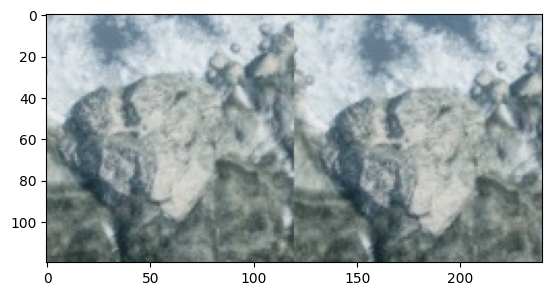

In [141]:
file = RAW_PATH / 'train/train/0a02efa28a78402c1c50322970cc2728.jpg'
print(file)
img = cv2.imread(str(file))
show_raw(img)

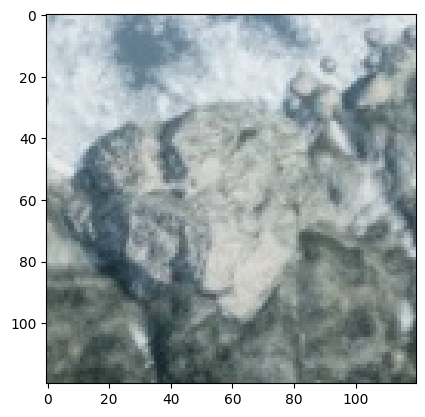

In [142]:
show_raw(img[:,:120,:])


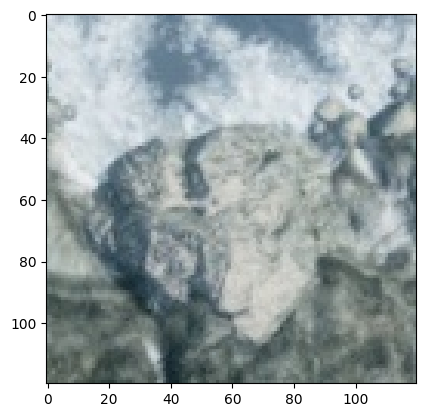

In [143]:
show_raw(img[:,120:,:])


In [ ]:
pub = pd.read_csv(RAW_PATH / 'public.csv')
pub.head()

,Filename,Altitude,Delta,North,East,kfold
0,00003e3b9e5336685200ae85d21b4f5e.jpg,178.829834,-0.065231,-0.386045,0.929772,0
1,0001261e2060303a06ba6c64d676d639.jpg,207.921478,-0.080688,0.635584,0.152819,2
2,0002ac0d783338cfeab0b2bdbd872cda.jpg,178.048431,0.021576,-1.228229,-0.499388,3
3,0004289ee1c7b8b08c77e19878106ae3.jpg,201.084625,0.505981,-1.739709,-0.699928,1
4,0004d0b59e19461ff126e3a08a814c33.jpg,187.550201,-0.328156,-0.169798,2.828752,0


In [182]:

def load_imgs(filename):
    img = cv2.imread(str(filename))
    img1 = img[:,:120,:]  
    img2 = img[:,120:,:]
    return img1, img2


In [201]:
def optical_flow_dif(img_fut, img):
    img_fut = cv2.cvtColor(img_fut, cv2.COLOR_BGR2GRAY)
    img = cv2.cvtColor(img, cv2.COLOR_BGR2GRAY)
    p = cv2.goodFeaturesToTrack(img, maxCorners=2500, qualityLevel=0.01, minDistance=10, blockSize=5)
    pfut, status, err = cv2.calcOpticalFlowPyrLK(img, img_fut, p, None, winSize=(15, 15))
    valid = status.ravel().astype(np.bool8)
    pts_fut, pts = pfut.reshape(-1, 2)[valid], p.reshape(-1, 2)[valid]
    dif = pts_fut - pts
    return dif


In [225]:
def get_pts(folder, files, n_pts):
    i = 0
    pts = []
    for file in files:
        img1, img2 = load_imgs(folder / file)
        dif = optical_flow_dif(img2, img1)
        if dif.shape[0] == 0:
            dif = np.zeros((n_pts,2))
            i+=1            
        idx = np.random.choice(range(dif.shape[0]), n_pts, replace=True)
        pts.append(dif[idx])
    print('Outliers:', i)
    return np.array(pts)

train_files = pub[~pub.North.isna()].Filename.values
train_pts = get_pts(RAW_PATH / 'train/train', train_files, 10)

Outliers: 30


In [226]:
test_files = pub[pub.North.isna()].Filename.values
test_pts = get_pts(RAW_PATH / 'test/test', test_files, 10)

In [ ]:
train_pts.shape